### PIPELINE OVERVIEW
+ graph with genes as nodes and edges
+ generate a matrix from nodes based on specific parameters (features, random walk, shortest path..)
+ multidimensional matrices > embedding with tsne into 2D or 3D 
----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE
----------

In [1]:
from multidimvis_main import *

_____
# 1 | SELECT ONE NETWORK GRAPH
_____

In [2]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
#df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})


no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']

G = G_cere

#edge_list = nx.write_edgelist(G, "Yeast_edgelist_directinteractiononly.txt")

# Essentiality Score
essentials = []
for i in ess_id:
    essentials.append('entrez gene/locuslink:'+str(i))
    
nonessentials = []
for i in no_ess_id:
    nonessentials.append('entrez gene/locuslink:'+str(i))
    
major_score = 1
minor_score = -1

d_essentiality_scores = node_essentiality_scores(G, essentials, nonessentials, major_score, minor_score)
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in G.nodes()}

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [4]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

df_gene_sym = pd.read_csv('output_csv/DF_gene_symbol_Human.csv', index_col=0)
l_features = list((df_gene_sym.to_dict()).values())

In [3]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 5785
Number of edges: 31237
Network density: 0.2%


_____
# 2 | SELECT ONF OF THE FOLLOWING DISTANCE MATRICES
_____

### + STRUCTURAL : Graph structure based
+ Adjacency
+ Random Walk with Restart
+ Centrality measures

#### IMPORT PRECALCULATED 

In [4]:
DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_'+organism+'.csv', index_col=0)

In [6]:
DM_adj

,66008,8473,2561,3759,22906,4928,1994,8481,81610,51361,...,10838,8001,51351,1551,51458,143903,10861,51471,221044,29965
66008,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8473,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2561,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3759,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22906,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
DM_m = pd.read_csv('output_csv/RWR_Dataframe_'+organism+'.csv', index_col=0)

In [5]:
DM_m 

,entrez gene/locuslink:853056,entrez gene/locuslink:850930,entrez gene/locuslink:854123,entrez gene/locuslink:856771,entrez gene/locuslink:851205,entrez gene/locuslink:851882,entrez gene/locuslink:854540,entrez gene/locuslink:855599,entrez gene/locuslink:850693,entrez gene/locuslink:851455,...,entrez gene/locuslink:9164927,entrez gene/locuslink:55689,entrez gene/locuslink:4300,entrez gene/locuslink:5578,biogrid:32279,biogrid:32106,entrez gene/locuslink:2540578,entrez gene/locuslink:851514,entrez gene/locuslink:856436,entrez gene/locuslink:947286
entrez gene/locuslink:853056,8.047591e-01,5.516404e-03,2.421652e-07,3.751632e-07,1.483387e-06,1.080123e-07,8.894014e-07,7.415051e-08,4.284975e-08,1.956050e-07,...,1.450610e-08,5.024475e-08,5.024475e-08,5.282208e-08,1.254200e-07,9.161152e-08,1.185749e-08,4.026526e-08,2.117759e-08,2.202103e-08
entrez gene/locuslink:850930,1.554623e-02,8.031988e-01,1.158080e-06,3.944885e-06,2.349756e-05,1.615603e-06,4.805780e-06,1.410074e-07,1.530144e-06,6.856984e-07,...,7.487666e-08,2.494042e-07,2.494042e-07,1.624738e-07,7.659688e-07,4.165253e-07,3.706206e-08,3.814987e-07,9.246235e-08,3.302050e-07
entrez gene/locuslink:854123,7.044807e-07,1.195437e-06,8.033517e-01,1.012707e-02,3.613760e-03,8.365255e-04,5.357068e-05,1.952179e-05,2.021944e-03,1.832217e-05,...,1.702183e-06,3.614550e-07,3.614550e-07,1.171647e-07,7.966974e-06,3.117583e-06,4.486960e-08,6.132183e-08,8.166370e-07,2.900100e-05
entrez gene/locuslink:856771,5.456919e-07,2.036070e-06,5.063534e-03,8.014095e-01,3.174545e-05,6.443053e-06,3.875591e-05,9.302752e-07,1.347138e-05,7.394112e-07,...,1.533779e-06,3.307099e-07,3.307099e-07,6.109911e-07,2.822261e-06,5.747136e-07,1.812755e-08,3.736698e-08,7.546343e-07,1.157864e-03
entrez gene/locuslink:851205,6.068401e-06,3.410937e-05,5.081851e-03,8.928409e-05,8.008064e-01,1.387637e-05,2.150741e-06,7.155396e-07,1.420117e-05,5.231691e-05,...,2.793958e-07,1.591456e-06,1.591456e-06,5.574119e-07,5.338442e-06,5.085185e-06,2.036500e-07,3.762707e-06,7.350037e-07,3.691367e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
biogrid:32106,8.328320e-09,1.343630e-08,9.742446e-08,3.591960e-08,1.130041e-07,1.918364e-08,1.190575e-08,2.402671e-09,3.377930e-08,7.429730e-09,...,5.954098e-09,3.183391e-08,3.183391e-08,3.942708e-09,4.045281e-07,8.010365e-01,6.974158e-10,1.754206e-08,2.993656e-09,3.477706e-09
entrez gene/locuslink:2540578,1.077954e-09,1.195550e-09,1.402175e-09,1.132972e-09,4.525556e-09,6.357436e-10,7.274061e-10,5.025716e-10,1.587337e-09,1.850035e-09,...,1.779600e-09,5.630168e-09,5.630168e-09,1.503220e-09,2.653104e-09,6.974158e-10,8.064947e-01,1.195788e-10,3.119472e-09,1.580566e-10
entrez gene/locuslink:851514,3.660478e-09,1.230641e-08,1.916307e-09,2.335436e-09,8.361571e-08,4.551679e-09,1.445606e-09,1.611016e-09,2.844106e-09,3.240348e-09,...,5.300674e-10,1.428782e-09,1.428782e-09,4.965596e-10,8.140435e-10,1.754206e-08,1.195788e-10,8.040237e-01,5.945872e-09,2.643369e-10
entrez gene/locuslink:856436,1.540188e-08,2.386125e-08,2.041593e-07,3.773171e-07,1.306673e-07,5.362922e-08,5.599498e-08,1.426301e-06,3.841036e-08,1.687104e-07,...,9.197725e-07,6.415905e-06,6.415905e-06,1.703279e-08,5.801154e-08,2.394925e-08,2.495577e-08,4.756698e-08,8.028896e-01,5.709543e-08


In [65]:
df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

l_features = []
for i in d_centralities.items():
    k=list(i)
    l_features.append(k)

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

DM_centralities.index = G.nodes()
DM_centralities.columns = G.nodes()

In [7]:
DM_centralities

,entrez gene/locuslink:853056,entrez gene/locuslink:850930,entrez gene/locuslink:854123,entrez gene/locuslink:856771,entrez gene/locuslink:851205,entrez gene/locuslink:851882,entrez gene/locuslink:854540,entrez gene/locuslink:855599,entrez gene/locuslink:850693,entrez gene/locuslink:851455,...,entrez gene/locuslink:9164927,entrez gene/locuslink:55689,entrez gene/locuslink:4300,entrez gene/locuslink:5578,biogrid:32279,biogrid:32106,entrez gene/locuslink:2540578,entrez gene/locuslink:851514,entrez gene/locuslink:856436,entrez gene/locuslink:947286
entrez gene/locuslink:853056,0.000000,0.009233,0.010031,0.000480,0.029180,0.000048,0.000014,0.000161,0.001482,0.000193,...,0.001403,0.003244,0.003244,3.188450e-03,3.214671e-03,3.233634e-03,0.003077,3.193220e-03,0.000265,3.222347e-03
entrez gene/locuslink:850930,0.009233,0.000000,0.000547,0.005852,0.010322,0.010308,0.009772,0.011768,0.018076,0.011219,...,0.017796,0.023343,0.023343,2.320741e-02,2.326732e-02,2.332447e-02,0.022908,2.322020e-02,0.012540,2.329715e-02
entrez gene/locuslink:854123,0.010031,0.000547,0.000000,0.006199,0.006648,0.011324,0.010463,0.012725,0.018950,0.011571,...,0.018752,0.024154,0.024154,2.411136e-02,2.408901e-02,2.418690e-02,0.023832,2.412403e-02,0.013541,2.418643e-02
entrez gene/locuslink:856771,0.000480,0.005852,0.006199,0.000000,0.022291,0.000818,0.000560,0.001188,0.003498,0.000871,...,0.003409,0.005958,0.005958,5.920985e-03,5.923384e-03,5.965445e-03,0.005778,5.927363e-03,0.001442,5.960897e-03
entrez gene/locuslink:851205,0.029180,0.010322,0.006648,0.022291,0.000000,0.031544,0.029553,0.033420,0.041694,0.030296,...,0.041630,0.048327,0.048327,4.850511e-02,4.826914e-02,4.849789e-02,0.048194,4.852113e-02,0.034650,4.856485e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
biogrid:32106,0.003234,0.023324,0.024187,0.005965,0.048498,0.002687,0.002927,0.001998,0.000339,0.002325,...,0.000386,0.000001,0.000001,9.806149e-07,7.938870e-07,0.000000e+00,0.000004,9.419067e-07,0.001705,3.476047e-07
entrez gene/locuslink:2540578,0.003077,0.022908,0.023832,0.005778,0.048194,0.002533,0.002785,0.001867,0.000289,0.002223,...,0.000329,0.000008,0.000008,1.201331e-06,6.449597e-06,3.795082e-06,0.000000,1.291025e-06,0.001582,2.292263e-06
entrez gene/locuslink:851514,0.003193,0.023220,0.024124,0.005927,0.048521,0.002642,0.002893,0.001960,0.000325,0.002310,...,0.000369,0.000004,0.000004,1.802414e-09,3.181673e-06,9.419067e-07,0.000001,0.000000e+00,0.001669,1.702239e-07
entrez gene/locuslink:856436,0.000265,0.012540,0.013541,0.001442,0.034650,0.000112,0.000208,0.000014,0.000526,0.000229,...,0.000469,0.001721,0.001721,1.665119e-03,1.697901e-03,1.704572e-03,0.001582,1.668584e-03,0.000000,1.691974e-03


### + FUNCTIONAL : Molecular Function

#### IMPORT PRECALCULATED 

In [ ]:
DM_MF = pd.read_csv('output_csv/DistanceMatrix_goMF_Dataframe_Human_cosine.csv', index_col=0)

DM_MF_mod = DM_MF.round(decimals=4)

In [ ]:
DM_MF = DM_MF_mod

In [ ]:
DM_MF

### + FUNCTIONAL : Cellular Components

#### IMPORT PRECALCULATED 

In [ ]:
DM_CC = pd.read_csv('output_csv/DistanceMatrix_goCC_Dataframe_Human_cosine.csv', index_col=0)

DM_CC_mod = DM_CC.round(decimals=4)

In [ ]:
DM_CC = DM_CC_mod

In [ ]:
DM_CC

### + FUNCTIONAL : Biological Processes

#### IMPORT PRECALCULATED 

In [ ]:
DM_BP = pd.read_csv('output_csv/DistanceMatrix_goBP_Dataframe_Human_cosine.csv', index_col=0)
    
DM_BP_mod = DM_BP.round(decimals=4)

In [ ]:
DM_BP_mod = DM_BP.round(decimals=4)

In [ ]:
DM_BP = DM_BP_mod

In [ ]:
DM_BP

### + FUNCTIONAL : Disease Annotation

#### IMPORT PRECALCULATED 

In [ ]:
DM_Disease = pd.read_csv('output_csv/DistanceMatrix_Disease_Dataframe_Human_cosine.csv', index_col=0)
    
DM_Disease_mod = DM_Disease.round(decimals=4)

In [ ]:
DM_Disease = DM_Disease_mod

In [ ]:
DM_Disease

_____
### SELECT THE DISTANCE MATRIX

In [8]:
#---------------
# STRUCTURAL
#---------------
#feature = 'adj'
#DM = DM_adj

feature = 'rwr'
DM = DM_m

#feature = 'centralities'
#DM = DM_centralities


#---------------
# FUNCTIONAL 
#---------------

#feature = 'bioproc'
#DM = DM_BP
#feat_matrix = pd.read_csv('output_csv/Features_GO_MolFunc_Dataframe_Human.csv', index_col=0)

#feature = 'molfunc'
#DM = DM_MF
#feat_matrix = pd.read_csv('output_csv/Features_GO_BiolProc_Dataframe_Human.csv', index_col=0)

#feature = 'cellcomp'
#DM = DM_CC
#feat_matrix = pd.read_csv('output_csv/Features_GO_CellComp_Dataframe_Human.csv', index_col=0)


#feature = 'disease'
#DM = DM_Disease
#feat_matrix = pd.read_csv('output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)


# set gene list (= G.nodes())
genes = []
for i in DM.index:
    genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

### GENERAL NODE + EDGE PARAMETERS

In [73]:
# Node, Edge colors

edge_width = 0.1
edge_color = 'lightgrey'

edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.1

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.2
size = list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list(draw_node_degree_3D(G, scalef).values())

### SPECIFIC NODE + EDGE PARAMETERS

+ COLOR > GRADIENT : BY DICT INPUT (e.g. different values for nodes, like Closeness Centrality) 

In [70]:
# ----------------------------------------------------        
# Define colour parameter with dict (gradient)
# ----------------------------------------------------        
color_method = 'clos'
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
pal = sns.color_palette('Reds', colour_count)
palette = pal.as_hex()

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours_hex = l_col_clos 


d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(pal):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col = list(d_node_colour_sorted.values())

colours = l_col

____________
# 2D 
____________

___
## PORTRAITS
___

### tSNE EMBEDDING 2D

In [133]:
prplxty = 30 # range: 5-50 / default = 30
density = 1.0  # default 12.
l_rate = 200 #default 200.
steps = 250 # min 250

metric = 'cosine'

In [134]:
%%time 
tsne = embed_tsne_2D(DM, prplxty, density, l_rate, steps, metric)

CPU times: user 49.8 s, sys: 1.26 s, total: 51 s
Wall time: 8.91 s


In [135]:
# MAIN (if not all G.nodes)
posG_tsne = get_posG_2D(genes, tsne)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))

# get center of points and define radius
xx=[]
yy=[]

for i in posG_tsne.values():
    xx.append(i[0])
    yy.append(i[1])

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)

xm, ym = max(posG_tsne.values())
r = math.sqrt((cx - xm)**2 + (cy - ym)**2)

x = r*np.cos(t)
y = r*np.sin(t)

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_tsne, **posG_rest}
posG_complete_tsne = {key:posG_all[key] for key in G.nodes()}

### tSNE CLUSTER Colors
+ https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

In [26]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_tsne).T

n_clus = 10
n_neigh = 2
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus, affinity='rbf')
 
clusterid = model.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict(G, d_node_clusterid)

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, 'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

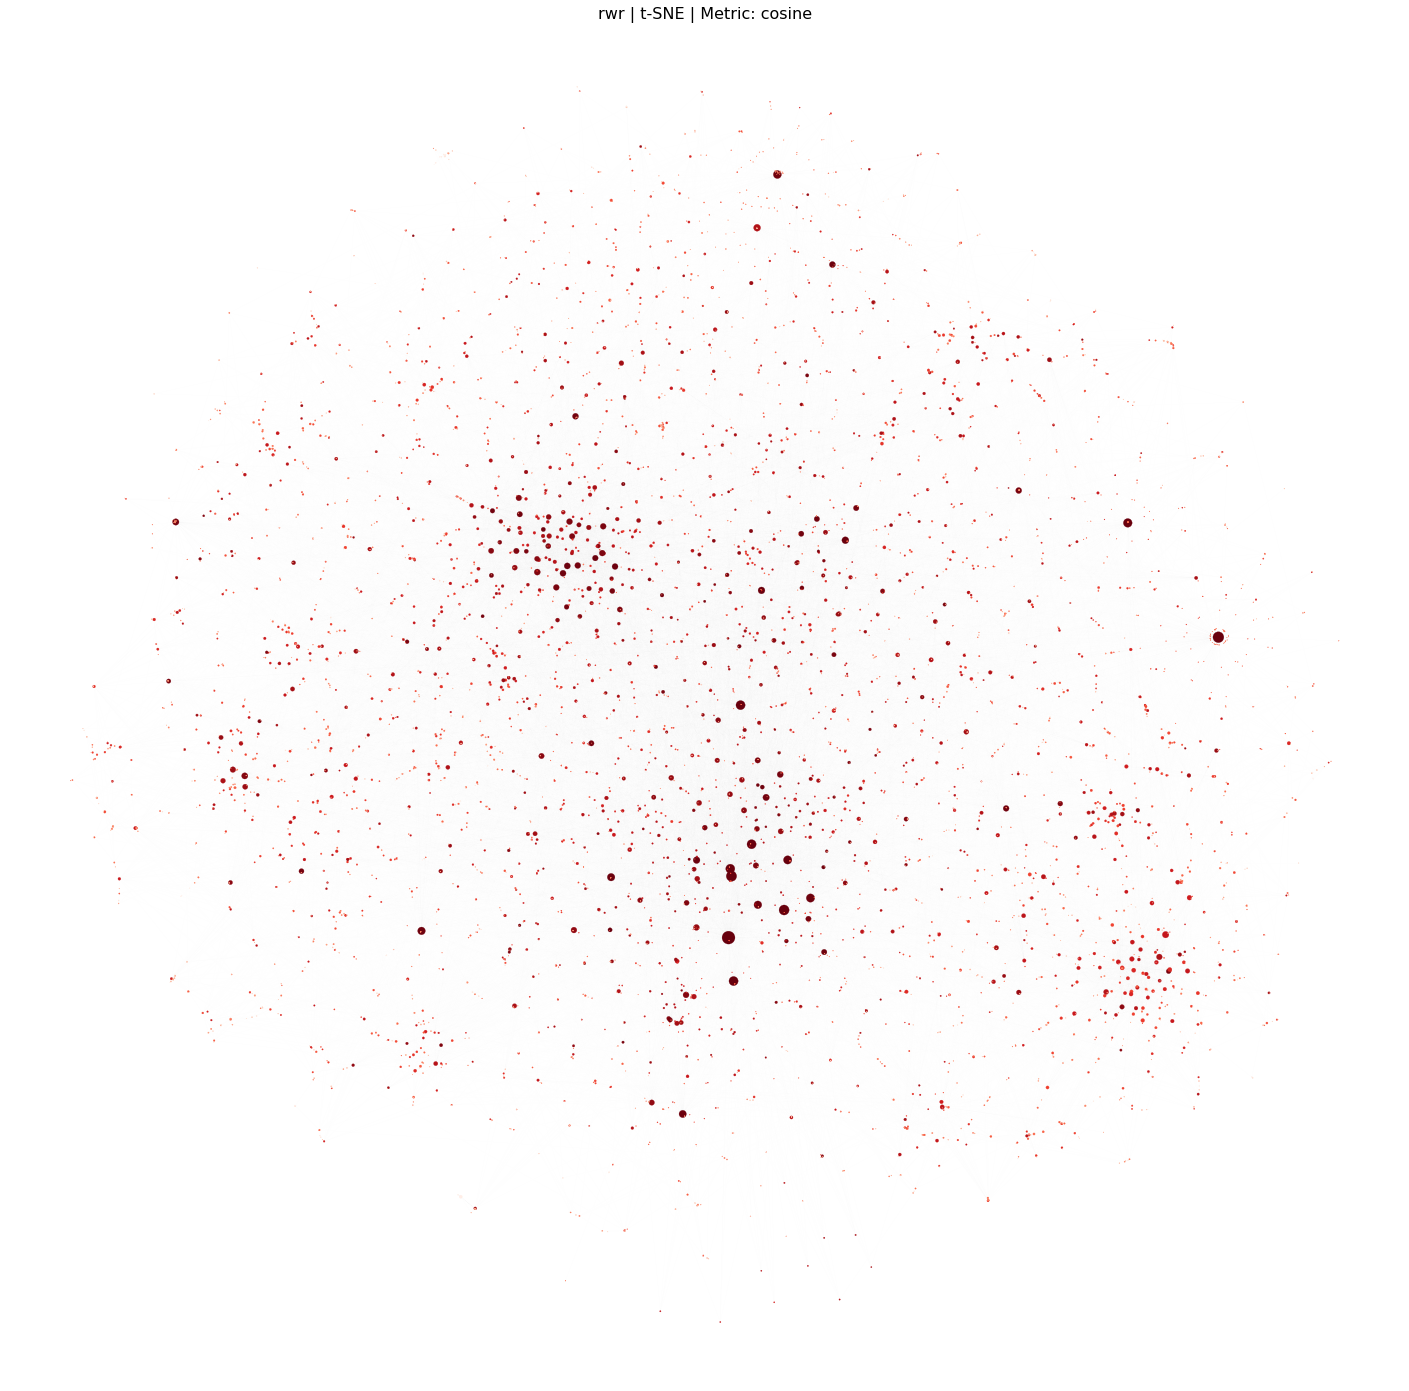

In [136]:
plt.figure(figsize=(25,25))
plt.title(feature+' | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG_complete_tsne, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_tsne, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dtsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'_nx.png')

plt.show()

#### TSNE EXPORT TO CSV

In [137]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [138]:
# EXPORT as dataframe

df_2Dportrait_tsne = pd.DataFrame(posG_complete_tsne).T
df_2Dportrait_tsne.columns=['x','y']
df_2Dportrait_tsne['z'] = 0

df_2Dportrait_tsne['r'] = colours_r
df_2Dportrait_tsne['g'] = colours_g
df_2Dportrait_tsne['b'] = colours_b
df_2Dportrait_tsne['a'] = colours_a

df_2Dportrait_tsne.to_csv(r'output_layout_csv/2Dtsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'.csv', index = True)

### UMAP EMBEDDING 2D 
+https://umap-learn.readthedocs.io/en/latest/embedding_space.html

In [11]:
n_neighbors = 50 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.001 # defines how dense points are stacked together 
metric ='cosine'

In [43]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 1min 48s, sys: 3.15 s, total: 1min 52s
Wall time: 1min 26s


In [56]:
# MAIN (if not all G.nodes)
posG_umap = get_posG_2D(genes, umap)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))

# get center of points and define radius
xx=[]
yy=[]
for i in posG_umap.values():
    xx.append(i[0])
    yy.append(i[1])

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)

xm, ym = max(posG_umap.values())
r = math.sqrt((xm-cx)**2 + (ym-cy)**2)

x = r*np.cos(t)
y = r*np.sin(t)

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_umap, **posG_rest}
posG_complete_umap= {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
for k,v in posG_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)

posG_complete_umap_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm)))

### UMAP CLUSTER Colors

In [ ]:
%%time 

# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_umap).T

n_clus = 50
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 2, affinity='nearest_neighbors')
clusterid = model.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict(G, d_node_clusterid)

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, 'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

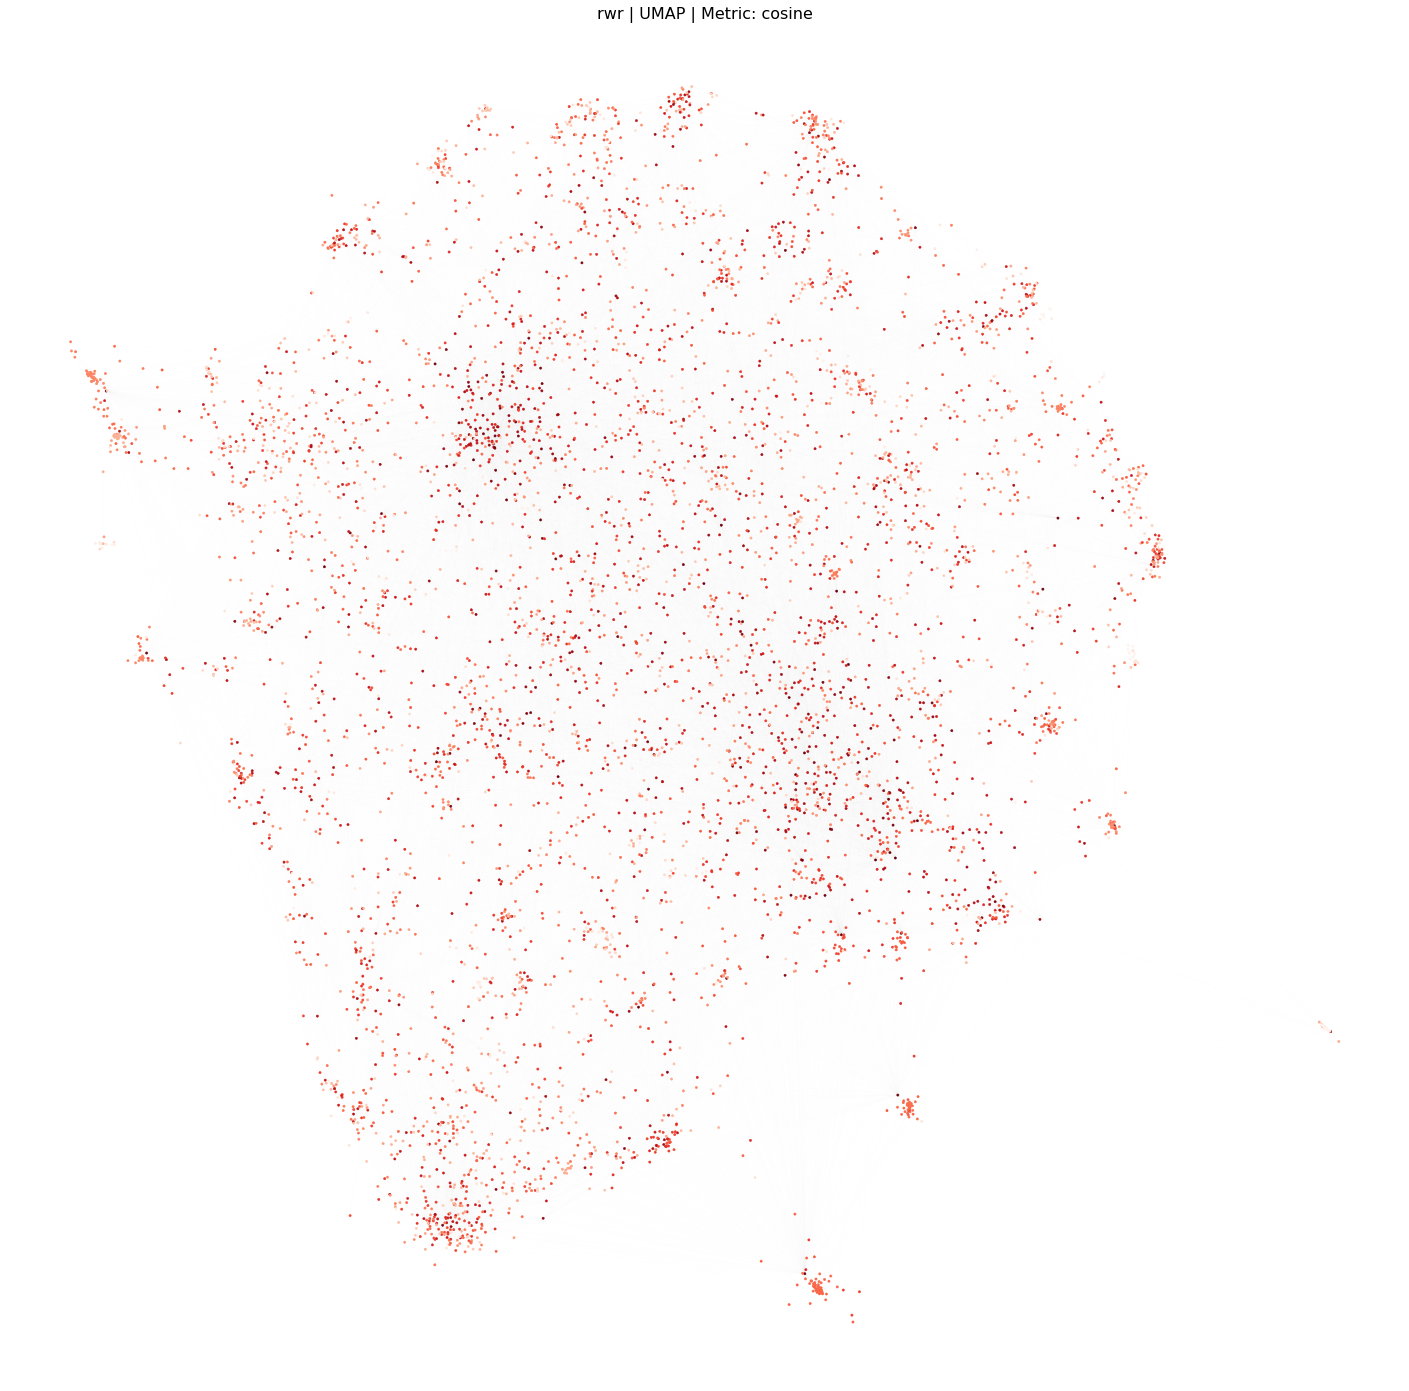

In [57]:
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 5, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_norm, width = edge_width, edge_color = edge_color, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2DPortraitumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

#### UMAP EXPORT TO CSV

In [59]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [60]:
# EXPORT as dataframe

df_2Dportrait_umap = pd.DataFrame(posG_complete_umap_norm).T

df_2Dportrait_umap.columns=['x','y']
df_2Dportrait_umap['z'] = 0

df_2Dportrait_umap['r'] = colours_r
df_2Dportrait_umap['g'] = colours_g
df_2Dportrait_umap['b'] = colours_b
df_2Dportrait_umap['a'] = colours_a

df_2Dportrait_umap.to_csv(r'output_layout_csv/2DPortraitumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.csv', index = True)

____________
# 3D
____________


____
## 3D PORTRAITS
____

## TSNE

In [ ]:
prplxty3d = 30 # range: 5-50 / default = 30.#
density3d = 1.2 # default 12.
l_rate3d = 200 # default 200.
steps3d = 250 #min 250

metric = 'cosine'

In [ ]:
%%time
tsne_3D = embed_tsne_3D(DM, prplxty3d, density3d, l_rate3d, steps3d)

In [32]:
# MAIN (if not all G.nodes)
posG_3Dtsne = get_posG_3D(genes, tsne_3D)

# REST (if genes = G.nodes then rest will be ignored / empty)

# get center of data points
xx=[]
yy=[]
zz=[]

for i in posG_3Dtsne.values():
    xx.append(i[0])
    yy.append(i[1])
    zz.append(i[2]) 

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)
cz = sum(zz)/len(genes)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest))
theta = pi * (1 + 5**0.5) * indices

xm, ym, zm = max(posG_3Dtsne.values())
r = math.sqrt((cx - xm)**2 + (cy - ym)**2 + (cz - zm)**2)
#r=1
x, y, z = cx+r*cos(theta) * sin(phi), cy+r*sin(theta) * sin(phi), cz+r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dtsne, **posG_rest}
posG_3D_complete_tsne = {key:posG_all[key] for key in G.nodes()}


# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_complete_tsne.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_complete_tsne_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

### tSNE CLUSTER Colors

In [ ]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3Dtsne).T

n_clus = 50
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 3, affinity='nearest_neighbors')
clusterid = model.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict(G, d_node_clusterid)

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, 'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

In [ ]:
tsne_nodes = get_trace_nodes(posG_3D_complete_tsne_norm, l_features, colours, 1)# size3d)
tsne_edges = get_trace_edges(G, posG_3D_complete_tsne_norm, edge_colordark)

tsne_data = [tsne_edges, tsne_nodes]
#tsne_data = [tsne_nodes]

In [ ]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_tsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'.html', auto_open=True)

#### TSNE 3D EXPORT Coordinates

In [ ]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [ ]:
# EXPORT as dataframe

df_3Dportrait_tsne = pd.DataFrame(posG_3D_complete_tsne_norm).T
df_3Dportrait_tsne.columns=['x','y','z']

df_3Dportrait_tsne['r'] = colours_r
df_3Dportrait_tsne['g'] = colours_g
df_3Dportrait_tsne['b'] = colours_b
df_3Dportrait_tsne['a'] = colours_a

df_3Dportrait_tsne.to_csv(r'output_layout_csv/3Dportrait_tsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'.csv', index = True)

## UMAP

In [115]:
n_neighbors = 4 # balance between local and global structure in the data
spread = 2.0
min_dist = 0.001 # defines how dense points are stacked together 
metric='cosine'

In [116]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 18.9 s, sys: 1.12 s, total: 20 s
Wall time: 11 s


In [117]:
# MAIN (if not all G.nodes)
posG_3Dumap = get_posG_3D(genes, umap_3D)

# REST (if genes = G.nodes then rest will be ignored / empty)

# get center of data points
xx=[]
yy=[]
zz=[]

for i in posG_3Dumap.values():
    xx.append(i[0])
    yy.append(i[1])
    zz.append(i[2]) 

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)
cz = sum(zz)/len(genes)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest))
theta = pi * (1 + 5**0.5) * indices

xm, ym, zm = max(posG_3Dumap.values())
r = math.sqrt((cx - xm)**2 + (cy - ym)**2 + (cz - zm)**2)
x, y, z = cx+r*cos(theta) * sin(phi),cy+r*sin(theta) * sin(phi), cz+r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dumap, **posG_rest}
posG_3D_complete_umap = {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_3D_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

### UMAP CLUSTER Colors

In [ ]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3Dumap).T

n_clus = 50
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 3, affinity='nearest_neighbors')
clusterid = model.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict(G, d_node_clusterid)

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, 'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

In [118]:
%%time 
umap_nodes = get_trace_nodes(posG_3D_complete_umap_norm, l_features, colours, 1) # size3d)
umap_edges = get_trace_edges(G, posG_3D_complete_umap_norm, 'lightgray') #edge_colordark) 

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 1.37 s, sys: 50 ms, total: 1.42 s
Wall time: 1.54 s


In [119]:
print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    

plotly.offline.plot(fig, filename = 'output_plots/3Dportrait_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.html', auto_open=True)

# Neighbours: 4
Spread: 2.0
Min. Distance: 0.001


'output_plots/3Dportrait_umap_rwr_cosine_clos_4_2.0_0.001_Yeast_clos.html'

#### UMAP PORTRAIT EXPORT Coordinates

In [120]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [122]:
# EXPORT as dataframe

df_3Dportrait_umap = pd.DataFrame(posG_3D_complete_umap_norm).T
df_3Dportrait_umap.columns = ['x','y','z']

df_3Dportrait_umap['r'] = colours_r
df_3Dportrait_umap['g'] = colours_g
df_3Dportrait_umap['b'] = colours_b
df_3Dportrait_umap['a'] = colours_a

df_3Dportrait_umap.to_csv(r'output_layout_csv/3DPortrait_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.csv', index = True)

In [ ]:
# IMPORT and convert df to dict 
df_umap_posG3d = pd.read_csv('output_layout_csv/3DPortrait_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.csv', index_col=0)
X_umap = list(df_umap_posG3d['x'])
Y_umap = list(df_umap_posG3d['y'])
Z_umap = list(df_umap_posG3d['z'])

umap_posG3d = dict(zip(list(G.nodes()),zip(X_umap,Y_umap,Z_umap)))

___
## LANDSCAPES
___

### Define z-parameter
+ Choose one
___________

In [ ]:
# Essentiality

dict_z = d_essentiality_scores_sorted
z_list = list(dict_z.values())

In [123]:
# Centrality Metrics average 

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[i] = round((j[0]+j[1]+j[2]+j[3])/4,2)
    
d_binned = bin_nodes(d_centr)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
dict_z = {key:d_node_bin[key] for key in G.nodes()}

z_list = list(dict_z.values())

In [14]:
# Function associated z-parameter

# feat_matrix is defined by the chosen Distance Matrix at the very beginning
features_counted = (feat_matrix == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes, list(features_counted)))
d_binned = bin_nodes(d_features_counted)

d_functions = {}
for k,v in d_binned.items():
    for each in v:
        d_functions[each] = k
        
d_rest = {}
for i in genes_rest: 
    d_rest[i] = 0
    
d_param_unsorted = {**d_functions, **d_rest}
dict_z = {key:d_param_unsorted[key] for key in G.nodes()}

z_list = list(dict_z.values())

________

### tSNE

In [ ]:
posG_land_tsne = {}
cc = 0
for k,v in posG_complete_tsne_norm.items():
    posG_land_tsne[k] = (v[0],v[1],z_list[cc])
    cc+=1

### tSNE CLUSTER colors > from 2D tsne

In [37]:
tsne_nodes = get_trace_nodes(posG_land_tsne, l_features, colours, size3d)
tsne_edges = get_trace_edges(G, posG_land_tsne, edge_colordark)

tsne_data = [tsne_edges, tsne_nodes]
#tsne_data = [tsne_nodes]

In [38]:
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0, 
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
    

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/Landscapes_tsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'.html', auto_open=True)

Perplexity: 50
Early Exaggeration: 1.0
Learning rate: 1000
Iterations: 250


'output_plots/Landscapes_tsne_centralities_cosine_Yeast.html'

#### TSNE LANDSCAPE EXPORT TO CSV

In [ ]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [ ]:
# t-SNE 

df_xyz_landscape_tsne = pd.DataFrame(posG_tsne, index=["x","y"]).T
df_xyz_landscape_tsne["z"] = z_list

df_xyz_landscape_tsne['r'] = colours_r
df_xyz_landscape_tsne['g'] = colours_g
df_xyz_landscape_tsne['b'] = colours_b
df_xyz_landscape_tsne['a'] = colours_a

df_xyz_landscape_tsne.to_csv(r'output_csv/landscape_tsne_XYZ_RGBA_'+feature+'_'+organism+'.csv', index = True)

### UMAP

In [125]:
posG_land_umap = {}
cc = 0
for k,v in posG_complete_umap_norm.items():
    posG_land_umap[k] = (v[0],v[1],z_list[cc])
    cc+=1

### UMAP CLUSTER Colors > from 2D umap 

In [130]:
umap_nodes = get_trace_nodes(posG_land_umap, l_features, colours, 1) #size3d)
umap_edges = get_trace_edges(G, posG_land_umap, edge_colordark)

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

In [131]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)


fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      aspectratio=dict(
                        x=1,
                        y=1,
                        z=1
                    ),
                    camera=dict(
                        center=dict(
                            x=0,
                            y=0,
                            z=0
                        ),
                        eye=dict(
                            x=1.96903462608,
                            y=-1.09022831971,
                            z=0.405345349304
                        ),
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        )
                    ),
                    dragmode="turntable",
                    #annotations=annotations,
                ))


#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/Landscapes_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.html', auto_open=True)

# Neighbors:  4
Spread:  2.0
Min. Distance:  0.001
Metric:  cosine


'output_plots/Landscapes_umap_rwr_cosine_clos_4_2.0_0.001_Yeast_clos.html'

#### UMAP LANDSCAPE EXPORT TO CSV

In [132]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [136]:
# UMAP 

df_xyz_landscape_umap = pd.DataFrame(posG_land_umap, index=["x","y","z"]).T

df_xyz_landscape_umap['r'] = colours_r
df_xyz_landscape_umap['g'] = colours_g
df_xyz_landscape_umap['b'] = colours_b
df_xyz_landscape_umap['a'] = colours_a

df_xyz_landscape_umap.to_csv(r'output_layout_csv/landscape_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.csv', index = True)

## SPHERE

#### UMAP

### Define r-parameter
+ Choose one
___________

In [65]:
# Essentiality
d_param = d_essentiality_scores_sorted

In [ ]:
# Closeness Centrality
d_clos_r = {}
for i,j in d_clos.items():
    d_clos_r[i] = round(j,2)
    
d_binned = bin_nodes(d_clos_r)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [170]:
# Degree Centrality
d_degs_r = {}
for i,j in d_deghubs.items():
    d_degs_r[i] = round(j,2)
    
d_binned = bin_nodes(d_degs_r)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in G.nodes()}

In [197]:
# Centrality Metrics average 
d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[i] = round((j[0]+j[1]+j[2]+j[3])/4,2)
    
d_binned = bin_nodes(d_centr)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
d_param = {key:d_node_bin[key] for key in genes}  #G.nodes()}

In [ ]:
# Function associated z-parameter

# feat_matrix is defined by the chosen Distance Matrix at the very beginning
features_counted = (feat_matrix == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes, list(features_counted)))
d_binned = bin_nodes(d_features_counted)

d_functions = {}
for k,v in d_binned.items():
    for each in v:
        d_functions[each] = k
        
d_rest = {}
for i in genes_rest: 
    d_rest[i] = 0
    
d_param_unsorted = {**d_functions, **d_rest}
d_param = {key:d_param_unsorted[key] for key in G.nodes()}

______

In [138]:
n_neighbors = 4 # balance between local and global structure in the data
spread = 2.0
min_dist = 0.001 # defines how dense points are stacked together 
metric='cosine'

In [139]:
%%time 
umap_sphere = embed_umap_sphere(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 16.4 s, sys: 1.01 s, total: 17.4 s
Wall time: 9.9 s


In [140]:
%%time
posG_3Dsphere = get_posG_sphere(genes, umap_sphere)

CPU times: user 3.59 ms, sys: 1.37 ms, total: 4.97 ms
Wall time: 3.92 ms


In [151]:
# REST (if genes = G.nodes then rest will be ignored / empty)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest))
theta = pi * (1 + 5**0.5) * indices

r = 0.5
x, y, z = r*cos(theta) * sin(phi), r*sin(theta) * sin(phi), r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dsphere, **posG_rest}
posG_complete_sphere = {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_complete_sphere.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

### SPHERE Colors 

In [204]:
#color_method = 'function'
#d_to_be_coloured = d_param

#color_method = 'essentiality'
#d_to_be_coloured = d_essentiality_scores_sorted # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)

In [205]:
# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
pal = sns.color_palette('bright', colour_count)
palette = pal.as_hex()

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]  
            
d_rest_grey = {}
for i in genes_rest: 
    d_rest_grey[i] = 'dimgrey'
    
d_all_colours = {**d_node_colour, **d_rest_grey}
d_all_colours_sorted = {key:d_all_colours[key] for key in G.nodes()}

colours = list(d_all_colours_sorted.values())

In [152]:
sphere_nodes = get_trace_nodes(posG_complete_sphere_norm, l_features, colours, 1) #size3d)
sphere_edges = get_trace_edges(G, posG_complete_sphere_norm, 'lightgray') #edge_colordark)

sphere_data = [sphere_edges, sphere_nodes]
#sphere_data = [sphere_nodes]

In [153]:
print('Metric:', metric)

fig = pgo.Figure()
for i in sphere_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, autosize = True,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      #aspectratio=dict(
                      #  x=1,
                      #  y=1,
                      #  z=1
                    #),
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dsphere_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.html', auto_open=True)

Metric: cosine


'output_plots/3Dsphere_umap_rwr_cosine_clos_4_2.0_0.001_Yeast_clos.html'

### R-Parameter

In [171]:
%%time 
posG_sphere_withrad = get_posG_with_sphere_radius(G, posG_complete_sphere, d_param)

CPU times: user 1min 5s, sys: 198 ms, total: 1min 5s
Wall time: 1min 5s


In [172]:
# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_sphere_withrad.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_sphere_withrad_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

In [173]:
sphere_nodes = get_trace_nodes(posG_sphere_withrad_norm, l_features, colours, 2) # size3d)
sphere_edges = get_trace_edges(G, posG_sphere_withrad_norm, edge_colordark)

sphere_data = [sphere_edges, sphere_nodes]
#sphere_data = [sphere_nodes]

In [174]:
print('Metric:', metric)

fig = pgo.Figure()
for i in sphere_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, autosize = True,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      #aspectratio=dict(
                      #  x=1,
                      #  y=1,
                      #  z=1
                    #),
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dsphere_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.html', auto_open=True)

Metric: cosine


'output_plots/3Dsphere_umap_rwr_cosine_clos_4_2.0_0.001_Yeast_clos.html'

#### UMAP SPHERE EXPORT TO CSV

In [175]:
colours_r = []
colours_g = []
colours_b = []
colours_a = []
for i in colours:
    colours_r.append(i[0])
    colours_g.append(i[1])
    colours_b.append(i[2])
    colours_a.append(0.9)

In [176]:
# UMAP 

df_xyz_sphere_umap = pd.DataFrame(posG_sphere_withrad, index=["x","y","z"]).T

df_xyz_sphere_umap['r'] = colours_r
df_xyz_sphere_umap['g'] = colours_g
df_xyz_sphere_umap['b'] = colours_b
df_xyz_sphere_umap['a'] = colours_a

df_xyz_sphere_umap.to_csv(r'output_layout_csv/sphere_umap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+color_method+'.csv', index = True)

# WORK IN PROGRESS

+ COLOR SPECIFIC GENES (LIST)

In [ ]:
# ----------------------------------------------------        
# Essential genes 
# ----------------------------------------------------  
     
color_method = 'Essentiality' 
color = 'blue'

l_genes = essentials

# n o d e s 
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
#d_edge_color_unsort = color_edges_from_genelist(G, l_genes, color)
#d_edge_color_sorted =  {key:d_edge_color_unsort[key] for key in G.edges()}
#edge_col = list(d_edge_color_sorted.values())

In [ ]:
def color_edges_from_genelist(G, l_genes, color):
    edge_lst = [(u,v) for u,v in G.edges(l_genes) if u in l_genes and v in l_genes]

    d_col_edges = {}
    for e in edge_lst:
        d_col_edges[e]=color
        
    d_nocol_edges = {}
    for e in G.edges():
        if e not in l_genes:
            d_nocol_edges[e]='lightgrey'
            
    d_both = {**d_col_edges, **d_nocol_edges}

    return d_both

In [ ]:
d_edge_color_unsort = color_edges_from_genelist(G, l_genes, color)

In [ ]:
# fix edge coloring 

In [ ]:
for i in d_edge_color_sorted.values():
    if i != 'lightgrey':
        print(i)

In [ ]:
# ----------------------------------------------------        
# Cancer Driver Genes
# ----------------------------------------------------  
     
color_method = 'Cancer Drivers' 
color = 'blue'

# n o d e s 
l_genes = l_cancerdrivers # my list of gene identifiers
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
edge_color = list(color_edges_from_genelist(G, l_genes, color).values())

In [ ]:
# ----------------------------------------------------        
# Rare disease genes 
# ----------------------------------------------------  
     
color_method = 'Rare Disease Genes' 
color = 'red'

# l_genes = 

# n o d e s 
# colours = color_nodes_from_genelist(G, l_genes, 'red')

# e d g e s 
# edge_color = color_edges_from_genelist(G, l_genes, color)

## ANNOTATIONS 

In [ ]:
# ----------------------------------------------------        
# annotations 
# ----------------------------------------------------        

# Choose Specific Gene to annotate 
geneid = '4790'
genesyn = d_geneid_IBDsyn['4790'] 

x_gene = posG[geneid][0]
y_gene = posG[geneid][1]
z_gene = posG[geneid][2]

annotations = [dict ( 
                x=x_gene,
                y=y_gene,            
                z=z_gene, 
                showarrow=True,
                text = 'IBD GENE: '+genesyn,
                ay = -100,
                ax = -100,
                opacity = 0.8,
                arrowhead = 0,
                arrowwidth = 0.5 ,
                arrowcolor = "white" 
            )]

annotations = [dict(
                x=max(posG.values())[0],
                y=max(posG.values())[1],
                showarrow=True,
                text=disease_category,
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

annotations3d = [dict(
                x=max(posG.values())[0],
                y=max(posG.values())[1],
                z=max(posG.values())[2],
                showarrow=True,
                text=disease_category,
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

## Biological Node Properties

## ESSENTIALITY

In [ ]:
# Essentiality Score
essentials = []
for i in ess_id:
    essentials.append('entrez gene/locuslink:'+str(i))
    
nonessentials = []
for i in no_ess_id:
    nonessentials.append('entrez gene/locuslink:'+str(i))
    
major_score = 1
minor_score = -1

d_essentiality_scores = node_essentiality_scores(G, essentials, nonessentials, major_score, minor_score)
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in G.nodes()}

In [ ]:
# add statistical test for checking for essentiality to degree - correlation

## CANCER DRIVERS 

## RARE DISEASE GENES

+ CLUSTERS COLOURED

# ADDITIONAL STUFF

+ HUBS COLOURED

In [ ]:
feature = 'HUBS'

df_centralities = pd.read_csv('output_csv/Features_centralities_Dataframe_Human.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(),df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

cutoff = 3 # number of considered hub nodes 
d_hub_nodes = identify_hubs(d_deghubs, d_clos, d_betw, cutoff)

colours = color_majornodes(G, d_hub_nodes)
#colours = color_nodes_from_dict(G,d_hub_nodes)
edge_color = color_majornodes_outgoingedges(G, d_hub_nodes)

# Annotations 

d_hub_coords = {}
for node,hub in d_hub_nodes.items():
    for k,v in posG.items():
        if node == str(k):
            d_hub_coords[node] = v
            
hub_x = []
hub_y = []
hub_z = []
for node,coords in d_hub_coords.items():
    hub_x.append(coords[0])
    hub_y.append(coords[1])
    hub_z.append(coords[2])
    
annotations = [dict(
                x=hub_x,
                y=hub_y,
                z=hub_z,
                showarrow=True,
                text="Hubs: "+str(i),
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                ) for i, hub_x, hub_y, hub_z in zip(range(1,len(d_hub_nodes)+1),hub_x, hub_y, hub_z)]

+ CLOSENESS CENTRALITY COLOR 

In [ ]:
feature = 'CLOSE'

# Define colour parameter
d_to_be_coloured = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
palette = sns.color_palette('Reds', colour_count)

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours = l_col_clos 

### COLOURING SUBCATEGORIES e.g. Disease subcategory (i.e. functional property)

In [ ]:
# input = dict

n = len(sub_categories)
colors = generate_colorlist_nodes(n)

doid_coloured = {}
c=0
for k,v in sub_categories.items():
    doid_coloured[k[1]]=colors[c]
    c+=1
    
d_gene_colours = {}
for doid, gene in d_do_genes.items(): 
    for i in gene:
        for do, col in doid_coloured.items():
            if doid == do:
                d_gene_colours[i]=col

# SORT dict based on G.nodes
d_gene_colours_sorted = {key:d_gene_colours[key] for key in G.nodes()}

l_col_subcat = list(d_gene_colours_sorted.values())


# NODE COLOURING based on Subcategory
colours = l_col_subcat 
edge_color = 'lightgrey'

#sns.palplot(colours)

### COLOURING DISEASE SCORES

In [ ]:
# TO DO : MAKE FUNCTION FOR COLORING 

gene_list = gene_list_retisarc



# COLOURS GENERATED / disease score and neighboring nodes

n = len(gene_list)
color_major = generate_colorlist_nodes(n)
 
factor = 1.7 # the higher the lighter
color_minor = []
for i in color_major:
    r,g,b = hex_to_rgb(i)
    color_light = adjust_color_lightness(r,g,b,factor)
    color_minor.append(color_light)
    
    
# ------------------------------------------------------
# NODES coloured 

# Major nodes coloured
d_col_major = {}
for n in d_major_score.keys():
    for i in color_major:
        d_col_major[n] = i

d_col_minor = {}
for node,col in d_col_major.items():
    for node in d_col_major.keys():
        for nd,neigh in major_neigh.items():
            for n in neigh:
                for i in color_minor:
                    if node==nd and n not in d_col_major.keys():
                        d_col_minor[n] = i
                    
d_col = {**d_col_major,**d_col_minor}

d_grey = {}
for i in G.nodes():
    if i not in d_col.keys():
        d_grey[i] = 'lightgrey'
        
        
d_col_all = {**d_col_major, **d_col_minor, **d_grey}
d_col_all_sorted = {key:d_col_all[key] for key in G.nodes()}

l_col_all = list(d_col_all_sorted.values())

colours = l_col_all

# ------------------------------------------------------
# EDGES coloured 

edge_lst = []
for edge in G.edges():
    for e in edge:
        for node in d_col_major.keys():
            if e == node:
                edge_lst.append(edge)
                
d_col_edges = {}
for e in edge_lst:
    for node,col in d_col_major.items():
        if e[0] == node:
            d_col_edges[e]=col
        elif e[1] == node:
            d_col_edges[e]=col

d_grey_edges = {}
for edge in G.edges():
    if edge not in d_col_edges.keys(): 
        d_grey_edges[edge] = 'lightgrey'
        
d_edges_all = {**d_col_edges, **d_grey_edges}

# Sort according to G.edges()
d_edges_all_sorted = {key:d_edges_all[key] for key in G.edges()}

edge_color = list(d_edges_all_sorted.values())